# Analyzing Electric Motor Temperatures with ASAM ODS 

This example Notebook shows how to implement [Kirgsn](https://www.kaggle.com/wkirgsn) example notebook [EDA and Baseline on Motor Temperature Estimation](https://www.kaggle.com/code/wkirgsn/eda-and-baseline-on-motor-temperature-estimation) from [Kaggl](https://www.kaggle.com) using *ASAM ODSBox*. 

The data are collected by the LEA (Power Electronics and Electrical Drives) Department of the Paderborn University from a permanent magnet synchronous motor (PMSM) which is deployed on a test bench: [Electric Motor Temperature](https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature). 


The first sections are on initializing and connecting. The fun starts with "Load data".

## Dependencies for this notebook

The [ASAM ODSBox](https://pypi.org/project/odsbox/) contains some functionality that wraps the ODS HTTP API making using Python easier ;-)

In [ ]:
try:  
  import odsbox
except:
  !pip install odsbox 
  
from odsbox.con_i import ConI
from odsbox.submatrix_to_pandas import submatrix_to_pandas

## Electric Motor Temperature

### Establish session

The ODS HTTP API is a session based API. The session ID is called con_i in the ODS documentation. The [ASAM ODSBox](https://pypi.org/project/odsbox/) uses con_i as API object representing the session. Close this session to release the connection license. Otherwise the session will be auto closed after 30 minutes of inactivity.

In [ ]:
con_i = ConI(url='https://docker.peak-solution.de:10032/api', auth=('Demo','mdm'))

### Import Libs

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
from sklearn.decomposition import PCA

### Load Data

The electric motor example data is stored in individual measurements starting with "Profile*" and we query für all (69) measurement (or more precisely their submatrices).

(We gave those measurements a random start date, which we use to order them by date...)

> The mass data hasn't been touched yet and we can examine it a bit before we actually load it - a bit like `shape` on steroids.

                SubMatrix.SubMatrixNoRows
MeaResult.Name                           
Profile_17                          15964
Profile_05                          14788
Profile_12                          21942
Profile_32                          20960
Profile_21                          17321


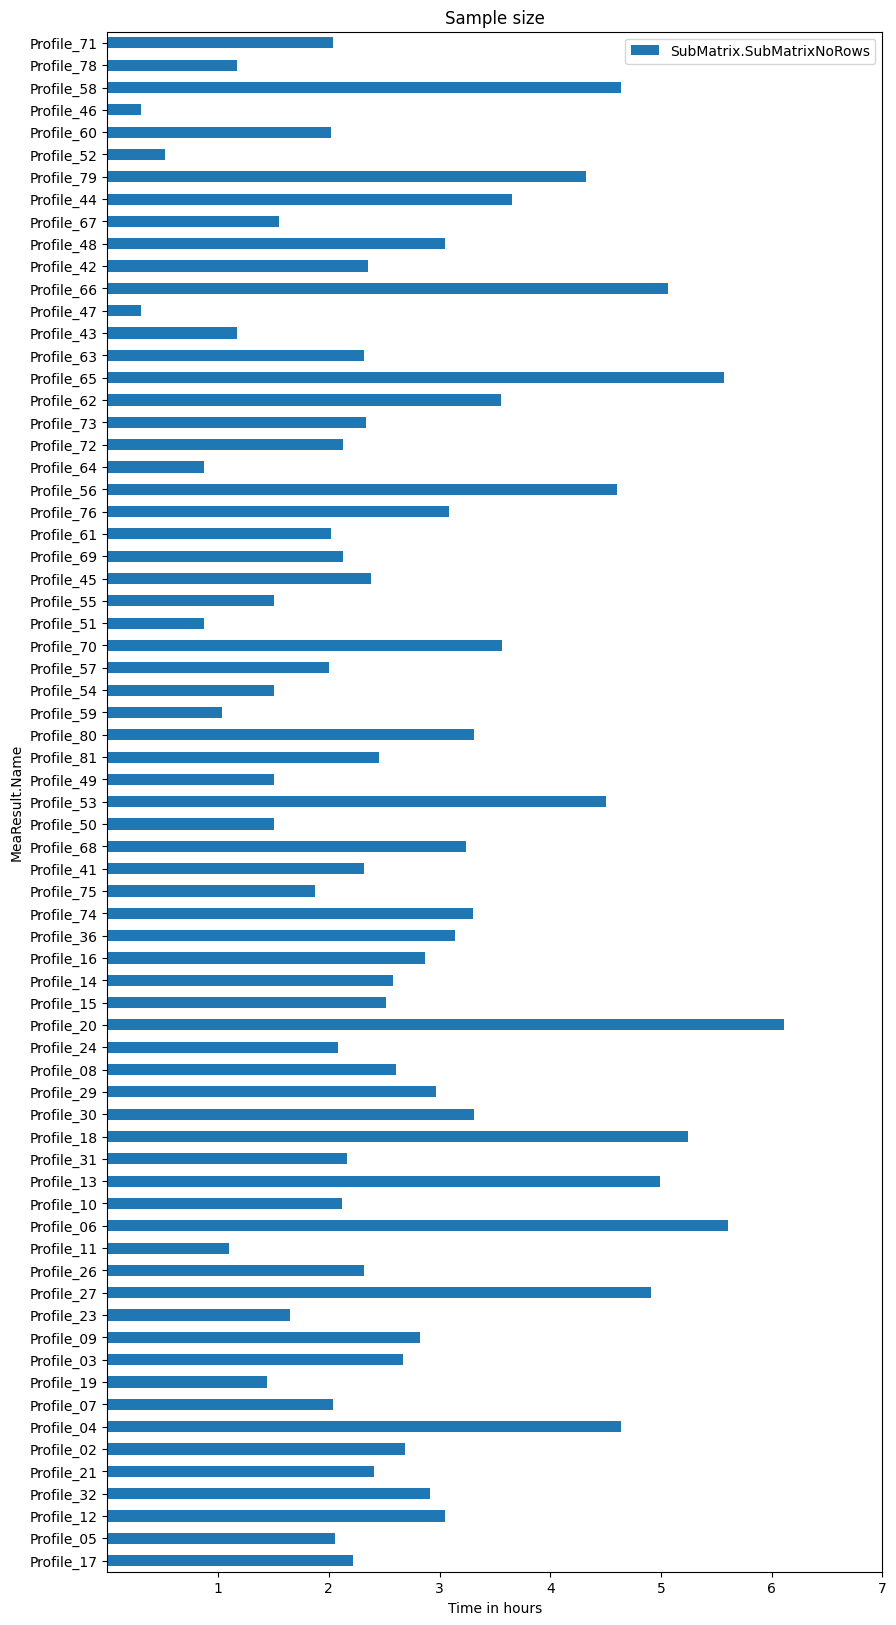

In [ ]:
mea_lenghts = con_i.query_data({
    "SubMatrix": {"measurement.test.Name": {"$like": "Profile*"}},
    "$attributes": {
        "measurement.Name": 1,
        "SubMatrixNoRows": 1
    },
    "$orderby": {
        "measurement.measurement_begin": 1
    }
})

mea_lenghts = mea_lenghts.set_index(mea_lenghts.columns[0])
print(mea_lenghts.head())


Plot sample size

In [ ]:

ax = mea_lenghts.plot.barh(figsize=(10, 20), title='Sample size')
_ = ax.set_xticks(2*3600*np.arange(1, 8)) # 2Hz sample rate
_ = ax.set_xticklabels(list(range(1, 8)))
_ = ax.set_xlabel('Time in hours')

Plot sample size distribution

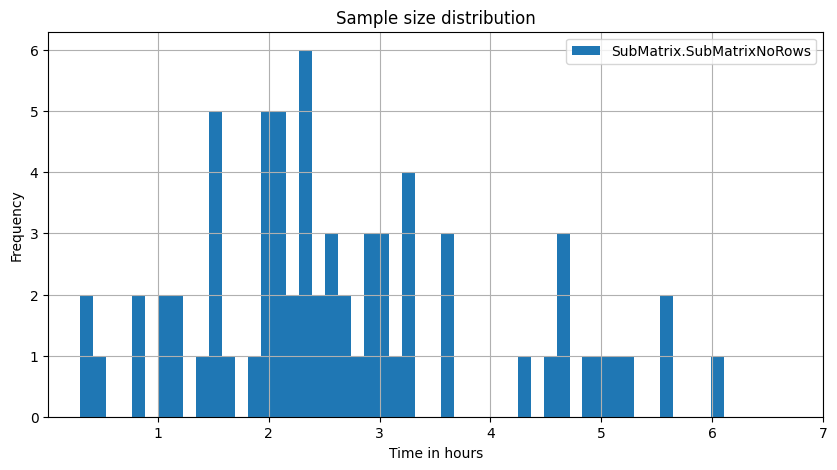

In [ ]:


ax = mea_lenghts.plot.hist(title='Sample size distribution', bins=50, figsize=(10, 5), grid=True)
_ = ax.set_xticks(2*3600*np.arange(1, 8)) # 2Hz sample rate
_ = ax.set_xticklabels(list(range(1, 8)))
_ = ax.set_xlabel('Time in hours')



### Distributions

Until now, we haven't loaded any mass data, yet. 

In our data model, the individual profiles are not contained in a big single dataset. They are stored profile by profile in so called submatrices (we looked at them before a bit). So we go and fetch the first profile returned as DataFrame by using `submatrix_to_pandas`. 

In [ ]:
data_matrices = con_i.query_data({
    "SubMatrix": {"measurement.name": "Profile_68"},
    "$attributes": {
        "measurement.Name": 1,
        "Id": 1
    }
})

# just pick the first one
dm_id = data_matrices["SubMatrix.Id"][0]
profile_name = data_matrices["MeaResult.Name"][0]

print(profile_name)

dm_df = submatrix_to_pandas(con_i, dm_id)
if "Time" in dm_df.columns:
    dm_df.set_index("Time", inplace=True)
elif "time" in dm_df.columns:
    dm_df.set_index("time", inplace=True)
dm_df.head()

Profile_68


,U_q,Coolant,Stator_winding,U_d,Stator_tooth,Motor_speed,I_d,I_q,Pm,Stator_yoke,Ambient,Torque
Time,,,,,,,,,,,,
0.0,-1.250622,26.948739,26.401552,-0.269267,26.165591,-0.003114,-2.000875,1.097745,28.011248,26.141670,26.280088,2.785112e-07
0.5,-0.510442,26.950800,26.396721,0.110050,26.172235,21.150647,-4.751546,-14.421556,28.002123,26.155253,26.275925,-1.122167e+01
1.0,-0.388580,26.953776,26.408694,0.907830,26.177153,42.000488,-15.815420,-49.228154,27.996198,26.159354,26.280659,-3.799358e+01
1.5,-0.260576,26.962654,26.401838,1.678359,26.181832,60.023822,-25.347121,-77.327501,27.993540,26.173699,26.280193,-5.986944e+01
2.0,0.134215,26.948778,26.396926,2.581367,26.172657,80.657265,-32.076248,-97.315560,28.001602,26.181490,26.277929,-7.541367e+01


... and now plot the distribution ....

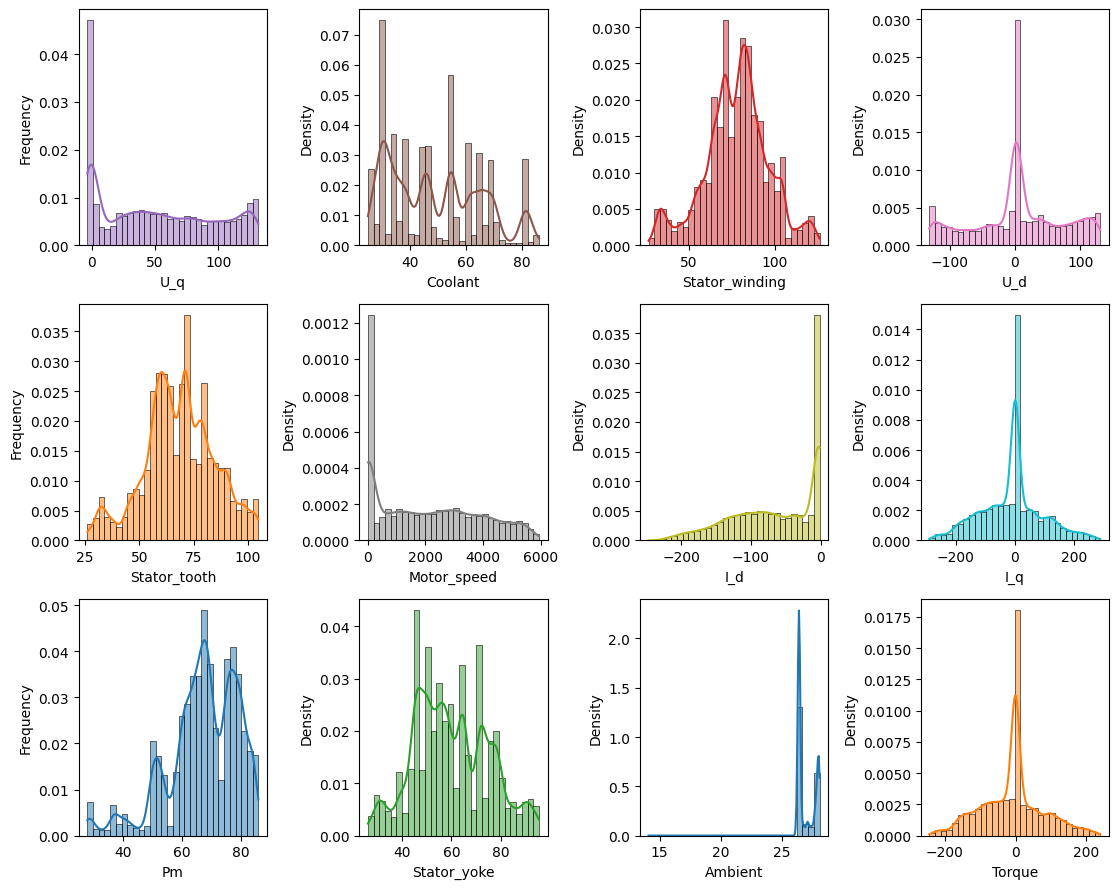

In [ ]:
target_features = ['Pm', 'Stator_tooth', 'Stator_yoke', 'Stator_winding']

# prepare colors
color_list = plt.cm.tab10(np.linspace(0, 1, 10)[list(range(10))+[0, 1]])
coi = target_features + [c for c in dm_df if c not in target_features]  # columns of interest
feat_clrs = {k: rgb2hex(color_list[i][:3]) for i, k in enumerate(coi)} if color_list is not None else {}

n_cols = 4
n_rows = np.ceil(dm_df.shape[1] / n_cols).astype(int)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.8*n_cols, n_rows*3))
for i, (ax, col) in enumerate(zip(axes.flatten(), list(dm_df.columns))):
    sns.histplot(dm_df[col], kde=True, stat="density", ax=ax, color=feat_clrs[col], bins=30)
    if i % n_cols == 0:
        ax.set_ylabel('Frequency')
plt.tight_layout()


### Time series gestalt

First we'll get an overview of the target temperature trends.


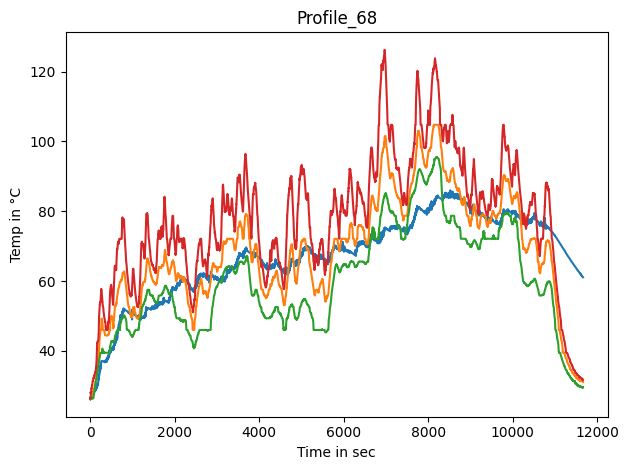

In [ ]:
dm_df = submatrix_to_pandas(con_i, dm_id)
if "Time" in dm_df.columns:
    dm_df.set_index("Time", inplace=True)
elif "time" in dm_df.columns:
    dm_df.set_index("time", inplace=True)

coi = target_features
fig, ax = plt.subplots()
for c in coi:
    lines = ax.plot(dm_df[c], label=c, color=feat_clrs[c])
ax.set_title(profile_name)
ax.set_ylabel('Temp in °C')
ax.set_xlabel('Time in sec')
    
fig.tight_layout()
# _ = ax.legend(ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)


Now we have a look at the input features

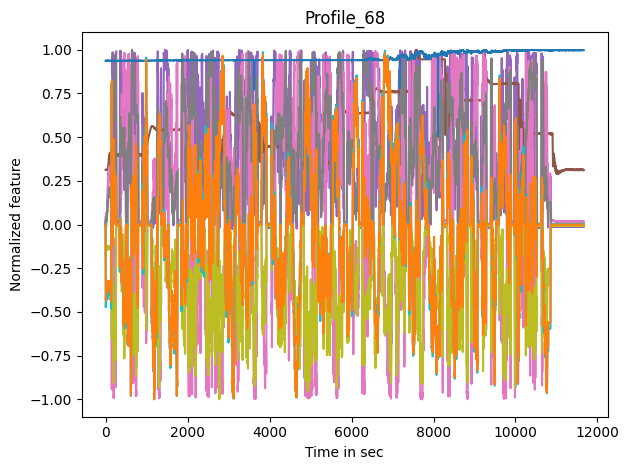

In [ ]:
coi = [c for c in dm_df if c not in target_features]
max_values_per_col = dm_df.abs().max(axis=0)
fig, ax = plt.subplots()
for c in coi:
    lines = ax.plot(dm_df[c]/max_values_per_col[c], label=c, color=feat_clrs[c])
ax.set_title(profile_name)
ax.set_ylabel('Normalized feature')
ax.set_xlabel('Time in sec')
fig.tight_layout()
#_ = ax.legend(ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

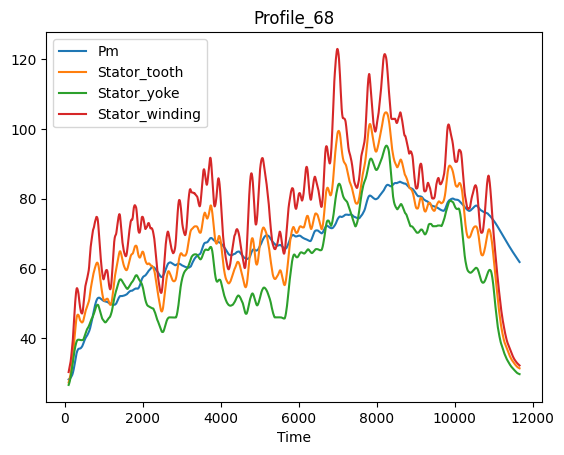

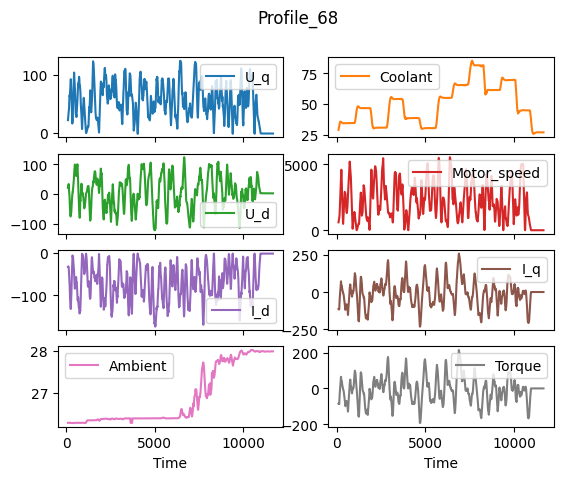

In [ ]:
_ = dm_df[target_features].rolling(200).mean().plot(kind="line", subplots=False, title=profile_name)
_ = dm_df.drop(target_features,axis=1).rolling(200).mean().plot(kind="line", subplots=True, layout=(4,2), title=profile_name)


### Operation points

The operation point of a motor is often explained by its location in the motor_speed-torque-plane.


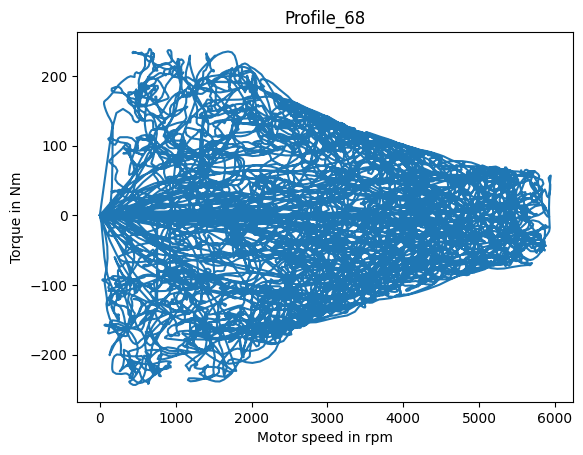

In [ ]:
fig, ax = plt.subplots()
_ = ax.plot(dm_df['Motor_speed'], dm_df['Torque'])
_ = ax.set_title(profile_name)
_ = ax.set_ylabel('Torque in Nm')
_ = ax.set_xlabel('Motor speed in rpm')

We see that some driving cycles only capture little of the valid operation region, while other profiles do comprehensive random walks over the full operative range.

Note that motors are power rated, and since power is defined as P=motorspeed⋅torque, there are elliptical borders that can't be exceeded.



### Dimensionality reduced visualization

Depict the sessions principal component axes, shifting the color from blue to red as the permanent magnet temperature rises.

Showing the two most significant principal components.


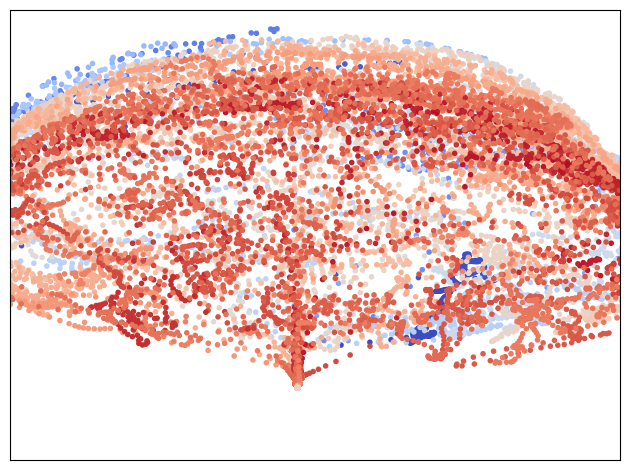

In [ ]:


# normalize
dm_df = submatrix_to_pandas(con_i, dm_id)

dm_df = dm_df / dm_df.abs().max(axis=0)
transformed = PCA().fit_transform(dm_df.drop(target_features, axis=1))
sess_df = dm_df
_trans = transformed[sess_df.index, :]
plt.scatter(_trans[:, 0], _trans[:, 1], c=dm_df.loc[sess_df.index, 'Pm'].values, cmap=plt.get_cmap('coolwarm'), marker='.', vmin=dm_df['Pm'].min(), vmax=dm_df['Pm'].max())
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                        labelbottom=False, right=False, left=False,
                        labelleft=False)
plt.tight_layout()



## Close session
Don't forget to close the session to release the connection license. Otherwise the session will be auto closed after 30 minutes of inactivity.

In [ ]:
con_i.logout()

## Acknowledgement  

The data used by this notebook is based on the Kaggle [Electric Motor Temperature](https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature) data provided by *Paderborn University* under the [CC BY-SA 4.0-License](
https://creativecommons.org/licenses/by-sa/4.0/)

## License

Copyright © 2025 [Peak Solution GmbH](https://peak-solution.de)

The training material in this repository is licensed under a Creative Commons BY-NC-SA 4.0 license. See [LICENSE](../LICENSE) file for more information.

**Notebook**: [📓 Back to ASAM ODS Overview](overview.ipynb)